In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from nilearn import datasets, plotting
import nibabel as nib
import matplotlib as mpl
from pathlib import Path

import sys; sys.path.append('../')
from src.tools import get_files, get_latents
# from src.plotting import visualize_embeddings, make_cbar

# import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

%load_ext autoreload
%autoreload 2

In [59]:
def plot_magitude_hists(groups, n_grad=3):
    fig, axes = plt.subplots(1, n_grad, figsize=(5*n_grad, 5), sharey=True)
    
    group_labels = [
        'Exper Resting State',
        'Expert Open Monitoring',
        'Expert Compassion',
        'Novice Resting State',
        'Novice Open Monitoring',
        'Novice Compassion',
    ]
    
    group_norms = [np.linalg.norm(g, axis=1) for g in groups]
    for i in range(n_grad):
        ax = axes[i]
        sns.violinplot(data=[norms[:, i] for norms in group_norms], ax=ax, orient='v')
#         for label, group in zip(group_labels, group_norms):
#             ax.hist(group[:, i], label=group_labels, alpha=0.25)
        ax.set_xticklabels(group_labels, rotation=75)
        ax.set_title(f'Gradient {i+1}')
    # axes[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].set_ylabel('Magnitude')
        
    plt.show()
    
def visualize_groups(groups, n_embed=3, hemi='left', view='lateral', stat=np.mean, save_file=None, normed=True):
    """
    groups : list, shape (6,)
        All six state by trait pairs. Assumed in order returned
        by 'get_latents' for labeling purposes.
    """
    fsa5 = datasets.fetch_surf_fsaverage()
    external_dir = '../data/external/'
    if hemi == 'left':
        cortex = nib.freesurfer.read_label(external_dir + 'lh.cortex.label')
        plot = fsa5.infl_left
    elif hemi == 'right':
        cortex = nib.freesurfer.read_label(external_dir + 'rh.cortex.label')
        plot = fsa5.infl_right
    
    ylabels = [
        'Expert\nResting State',
        'Expert\nOpen Monitoring',
        'Expert\nCompassion',
        'Novice\nResting State',
        'Novice\nOpen Monitoring',
        'Novice\nCompassion',
    ]

    plt.clf()
    res_scale = 2
    fig, axes = plt.subplots(n_embed, 6, subplot_kw={'projection': '3d'}, figsize=(res_scale*7, res_scale*n_embed))
    if n_embed==1:
        axes = [axes]
    plt.subplots_adjust(wspace=0, hspace=0)
    
    # Normalize
    if normed:
        groups = [g / np.linalg.norm(g, axis=1, keepdims=True) for g in groups]

    # Orient signs
    # np.random.seed(0)
    # sgn_ref = np.random.binomial(1, 0.5, (groups[0][0].shape[0]))
#     groups = [
#         np.asarray(g) * np.expand_dims(np.sign(np.tensordot(g, sgn_ref, axes=([1], [0]))), axis=1)
#         for g in groups
#     ]
    grad_sgn = np.sign(np.sum([np.asarray(groups[0])[:, 0, :].sum(0)], axis=0))
    groups = [
        np.asarray(g) * grad_sgn for g in groups
    ]
    
    groups = np.asarray([stat(g, axis=0) for g in groups])
    for r, row in enumerate(axes):
        vmax = np.max(np.abs(groups[:, :len(cortex), r]))
        for c, ax in enumerate(row):
            conn_map = np.zeros(10242)
            conn_map[cortex] = groups[c, :len(cortex), r]

            plotting.plot_surf_stat_map(plot,
              conn_map, hemi=hemi, colorbar=(c==len(row)-1), cmap='RdBu_r', view=view, axes=ax, 
                vmax=vmax, symmetric_cbar=True)
            if r == 0:
                ax.annotate(ylabels[c], xy = (0.5,1), xycoords='axes fraction', ha='center', fontsize=14)

        row[0].annotate(
            f'Gradient {r+1}', xy = (0,0.5), xycoords='axes fraction',
            rotation='vertical', va='center', fontsize=14)
        
    if save_file:
        plt.savefig(save_file, format='pdf', bbox_inches='tight')
    else:
        plt.show()

## GCCA embeddings

In [61]:
path = Path('/mnt/ssd3/ronan/data/gcca_09-22-21:18_min_rank-ZG3_exclude-073')
flag = f"_gcca"
ftype = "h5"
source='gcca'

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

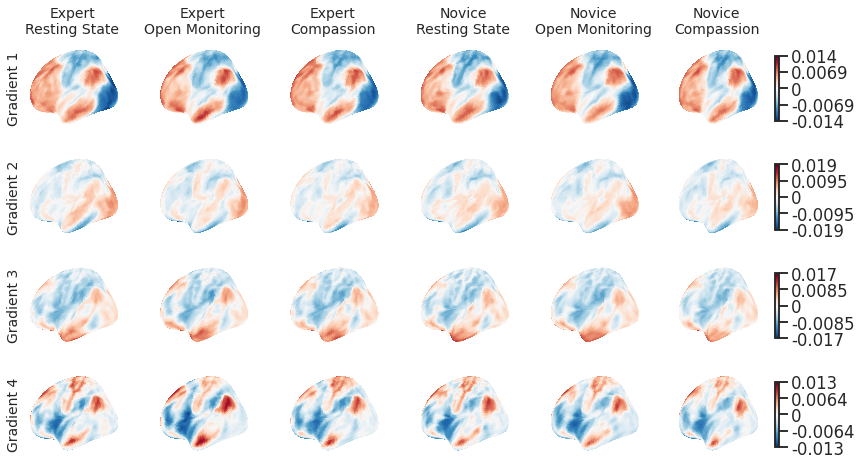

In [66]:
save_file = '../reports/figures/DCORR_gcca_raw_ZG3-min_normed/DCORR_gcca_raw_ZG3-min_normed_mean-gradients.pdf'
visualize_groups(groups, n_embed=4, stat=np.mean, save_file=save_file)

In [63]:
# visualize_groups(groups, n_embed=4, stat=np.mean, view='medial')

In [64]:
# save_file = '../reports/figures/DCORR_gcca_raw_ZG3-min_normed/DCORR_gcca_raw_ZG3-min_normed_std-gradients.pdf'
# visualize_groups(groups, n_embed=4, stat=np.std, save_file=save_file)

## dmap embeddings (align 5)

In [65]:
path = Path('/mnt/ssd3/ronan/data/dmap_replication-csv_align-5_01-09')
flag = '_dmap'
ftype = 'h5'
source='gcca'

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

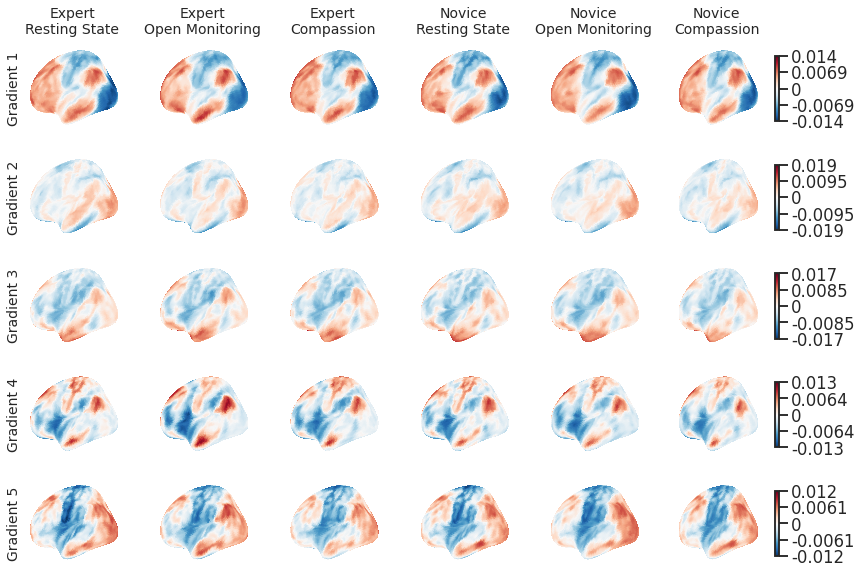

In [67]:
save_file = '../reports/figures/DCORR_dmap_mapalign_replication-csv_align-5_01-09/DCORR_dmap_mapalign_replication-csv_align-5_01-09_mean-gradients.pdf'
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True, save_file=save_file)

In [68]:
# visualize_groups(groups, n_embed=5, stat=np.mean, view='medial')

In [69]:
# save_file = '../reports/figures/DCORR_dmap_mapalign_replication-csv_align-5_01-09/DCORR_dmap_mapalign_replication-csv_align-5_01-09_std-gradients.pdf'
# visualize_groups(groups, n_embed=5, stat=np.std, save_file=save_file)

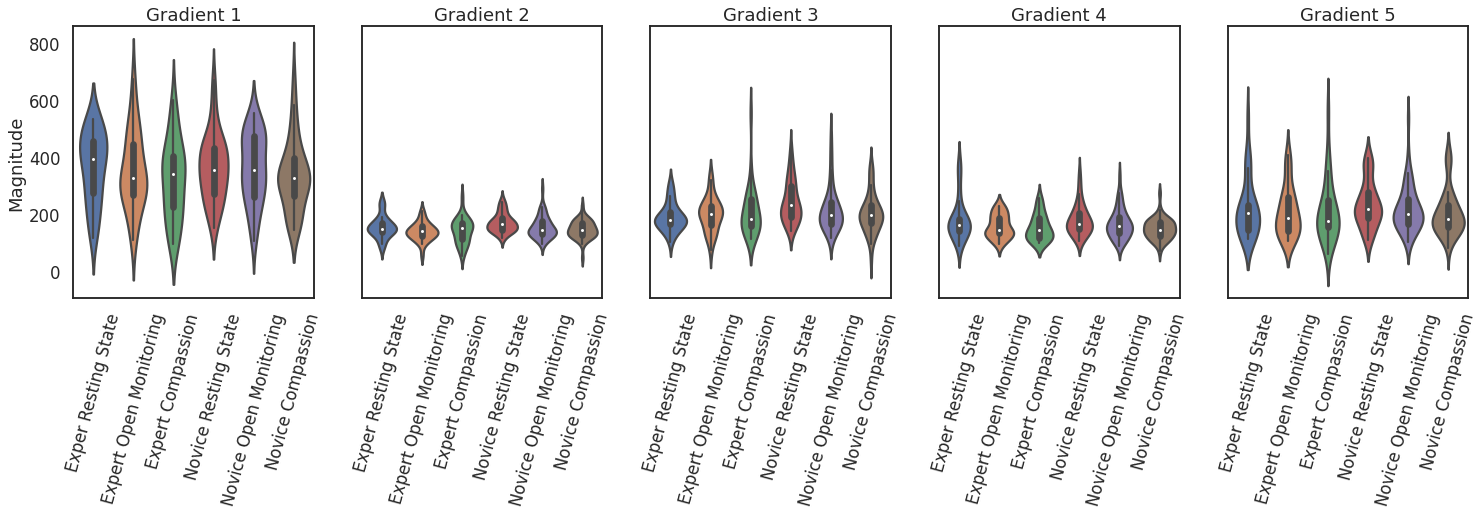

In [70]:
plot_magitude_hists(groups, n_grad=5)

## dmap, mean-align (5)

In [71]:
path = Path('/mnt/ssd3/ronan/data/dmap_replication-csv_mean-align-5_01-09')
flag = '_dmap'
ftype = 'h5'
source='gcca'

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

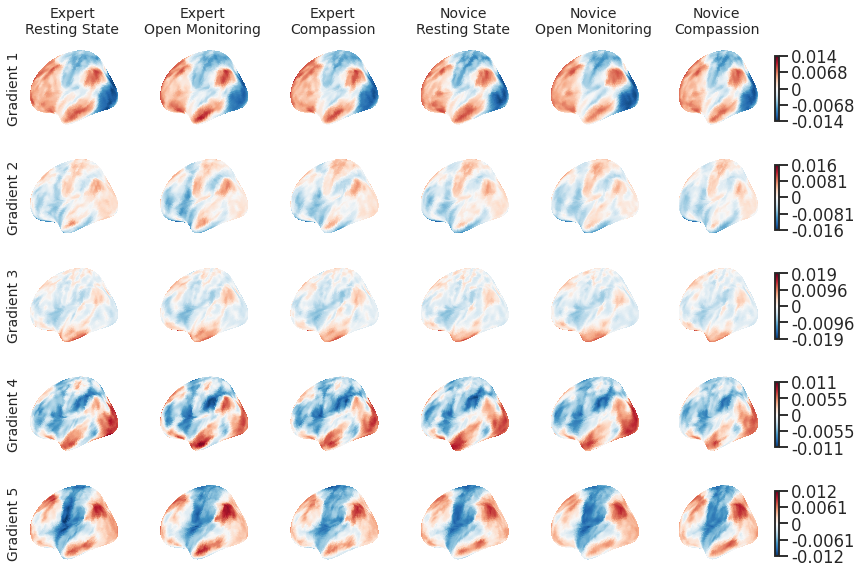

In [72]:
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True)

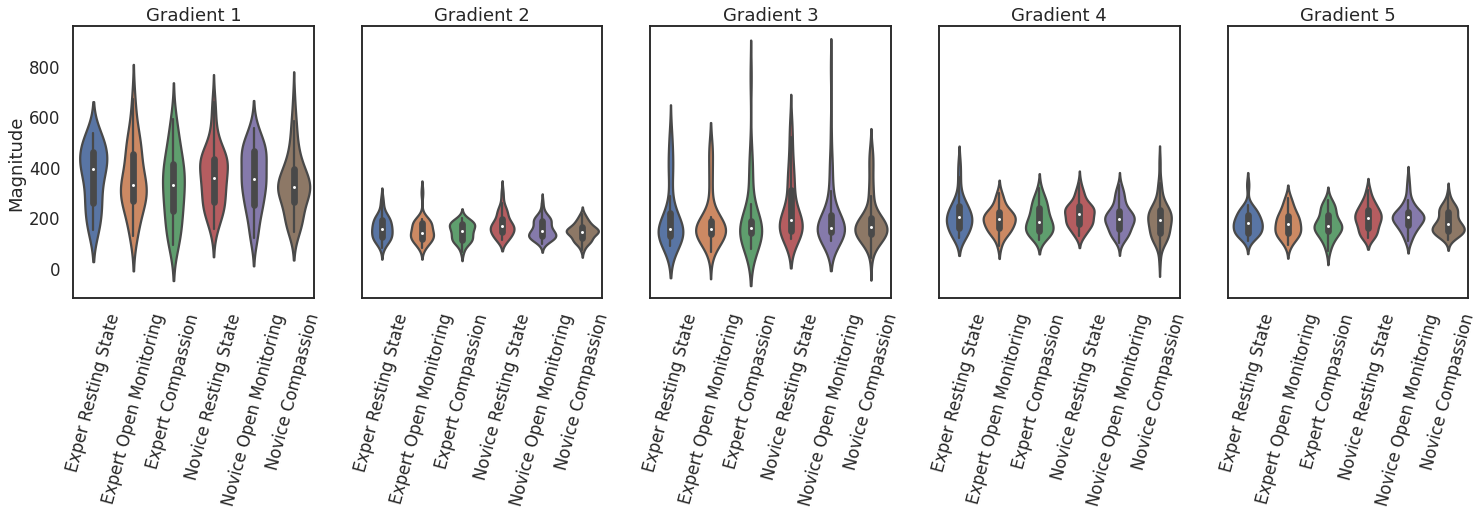

In [73]:
plot_magitude_hists(groups, n_grad=5)

### dmap (align 1)

In [74]:
path = Path('/mnt/ssd3/ronan/data/dmap_replication-csv_align-1_01-09')
flag = '_dmap'
ftype = 'h5'
source='gcca'

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

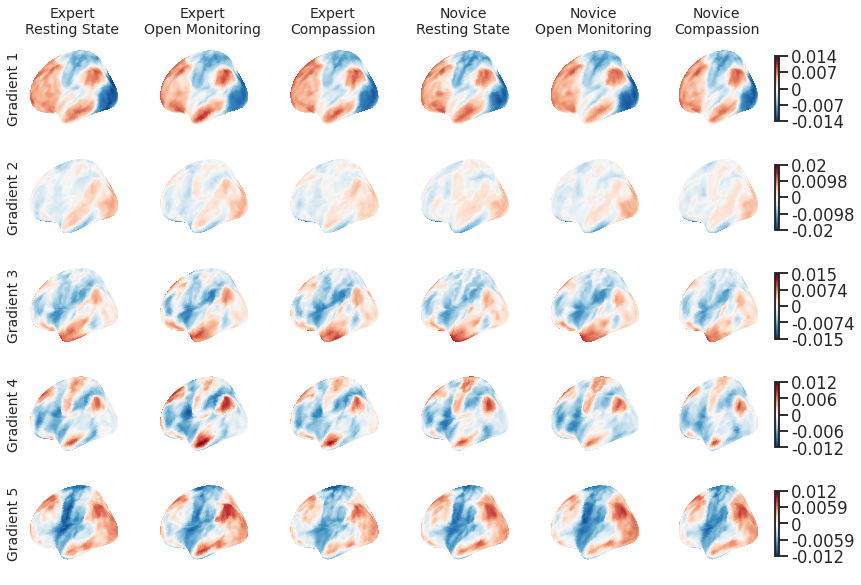

In [75]:
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True)

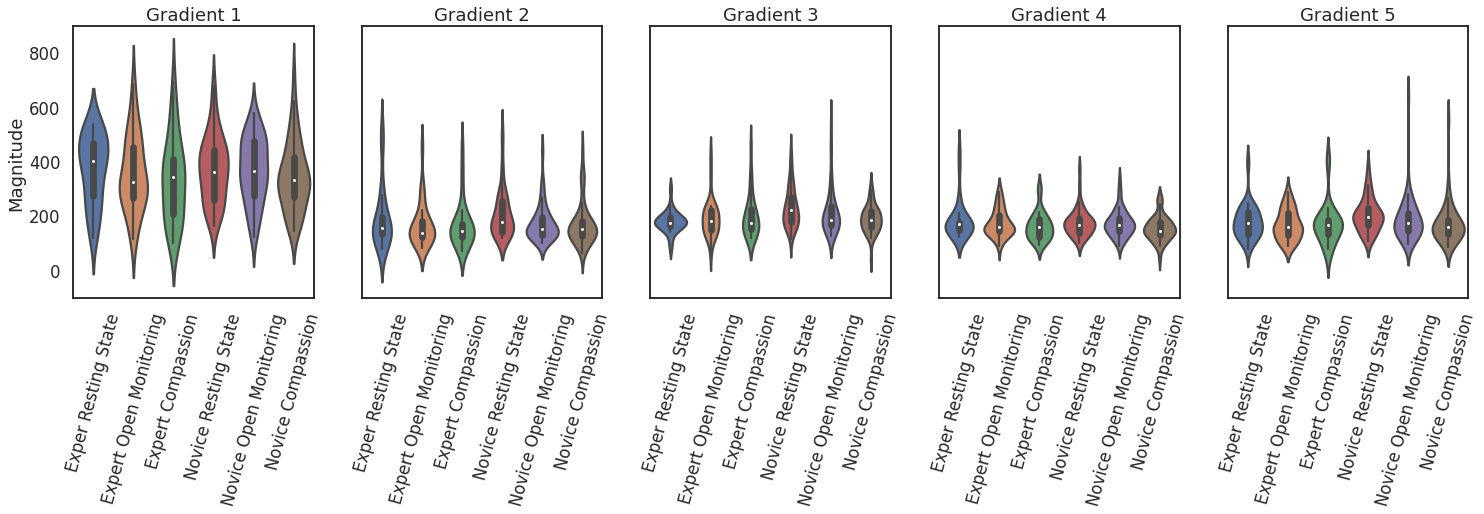

In [76]:
plot_magitude_hists(groups, n_grad=5)

## dmap svd align (unscaled, i.e. svd o norm=1 evecs)

In [77]:
path = Path('/mnt/ssd3/ronan/data/dmap_replication-csv_svd-align_01-09')
flag = '_dmap'
ftype = 'h5'
source='gcca'

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

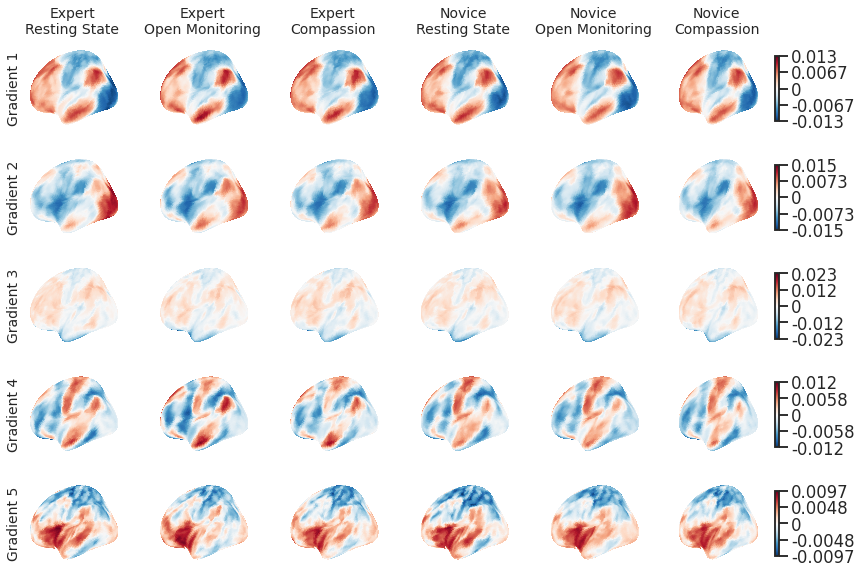

In [78]:
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True)

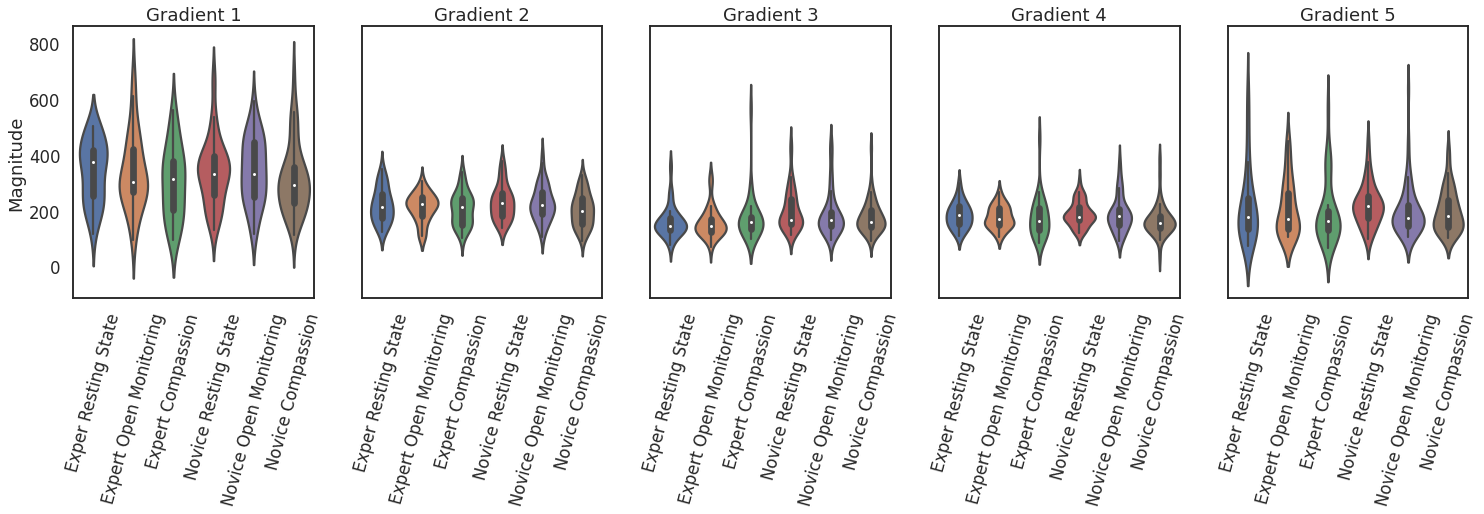

In [79]:
plot_magitude_hists(groups, n_grad=5)

## dmap svd-align (scaled)

In [80]:
path = Path('/mnt/ssd3/ronan/data/dmap_replication-csv_svd-align-scaled_01-09')
flag = '_dmap'
ftype = 'h5'
source='gcca'

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

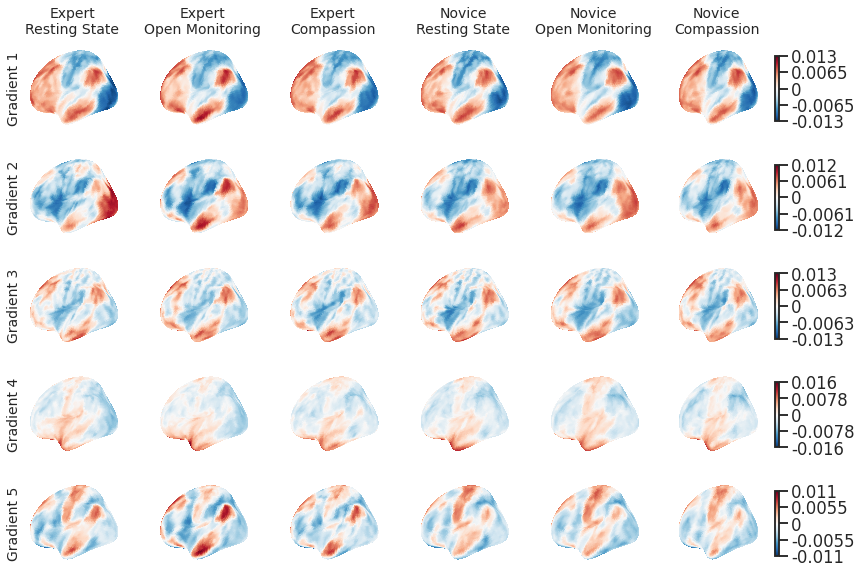

In [81]:
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True)

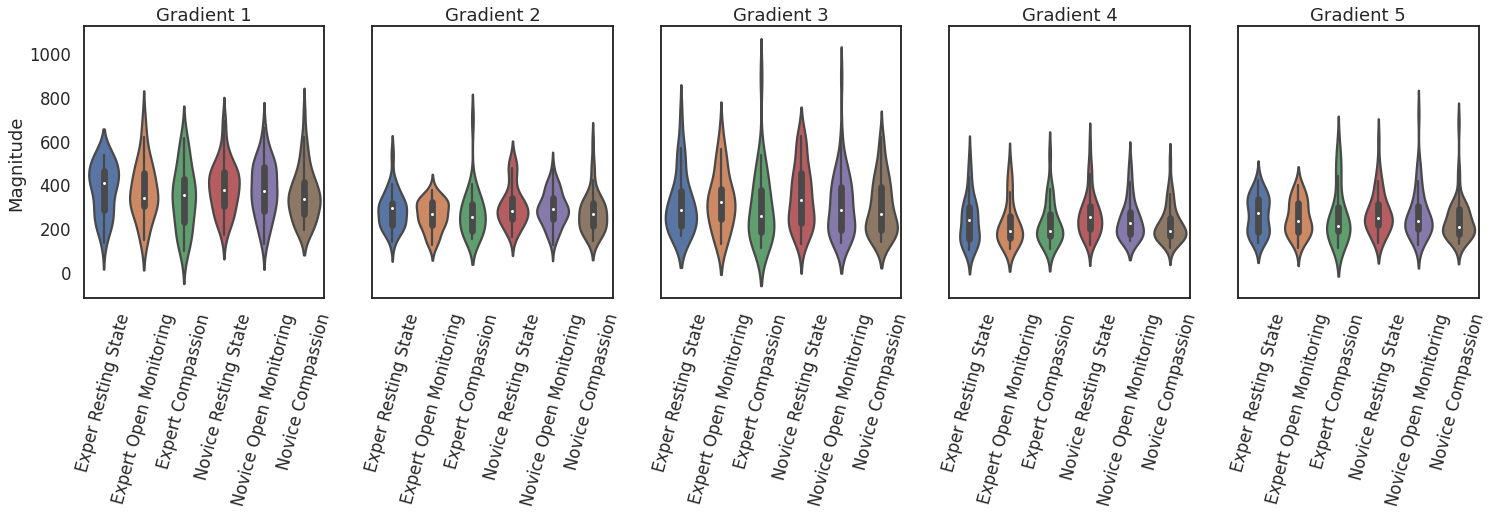

In [82]:
plot_magitude_hists(groups, n_grad=5)

## gcca, 5 components

In [83]:
path = Path('/mnt/ssd3/ronan/data/gcca_raw_ncomp-5_scaled_02-27')
flag = '_gcca'
ftype = 'h5'
source='gcca' # Yeah it's weird...

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

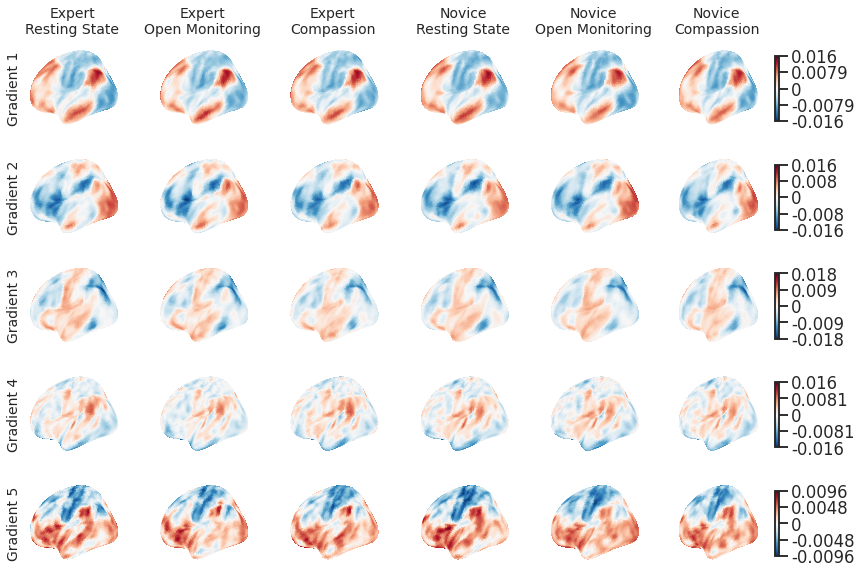

In [84]:
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True)

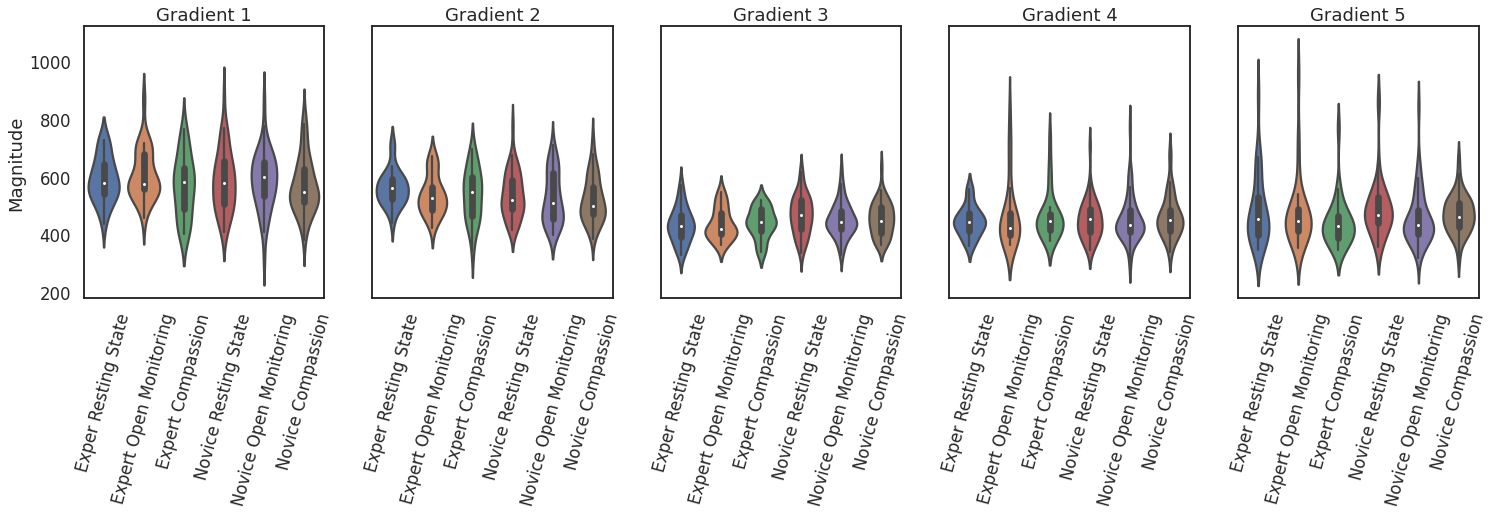

In [85]:
plot_magitude_hists(groups, n_grad=5)

## grouppca

In [86]:
path = Path('/mnt/ssd3/ronan/data/grouppca_raw_02-25')
flag = '_grouppca'
ftype = 'h5'
source='gcca' # Yeah it's weird...

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

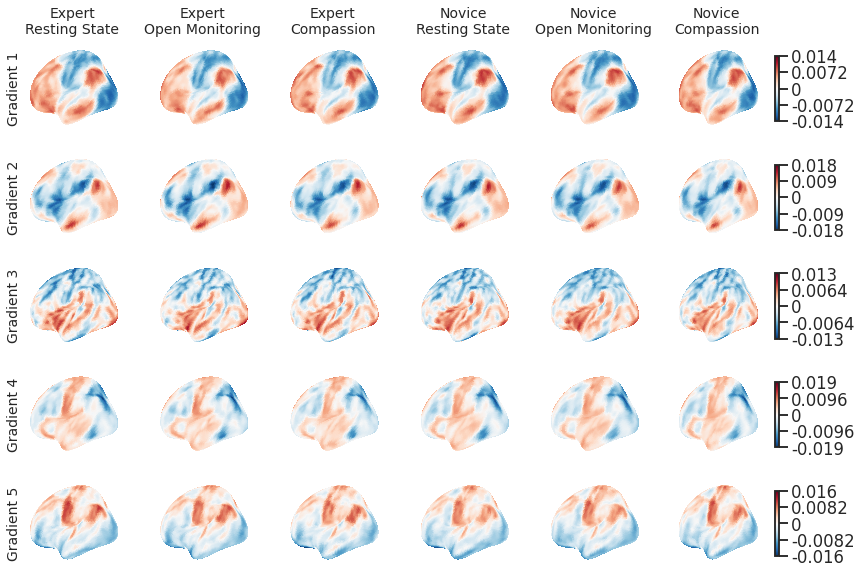

In [87]:
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True)

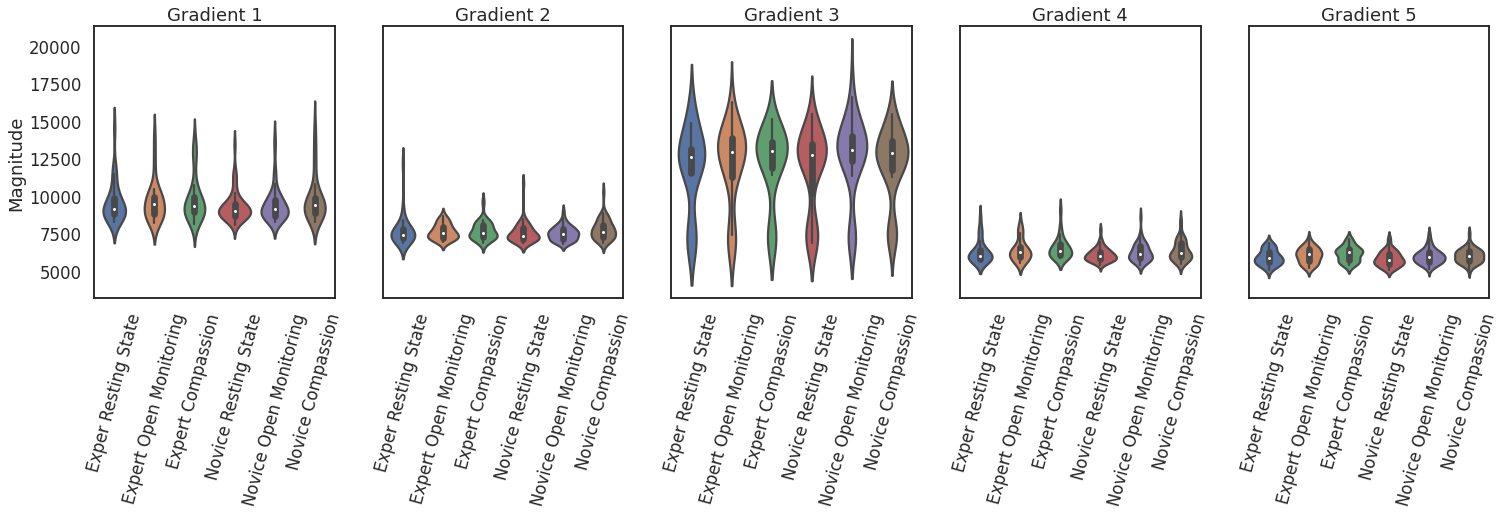

In [88]:
plot_magitude_hists(groups, n_grad=5)

## grouppca (prewhitened)

In [90]:
path = Path('/mnt/ssd3/ronan/data/grouppca_raw_prewhitened_02-26')
flag = '_grouppca'
ftype = 'h5'
source='gcca' # Yeah it's weird...

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

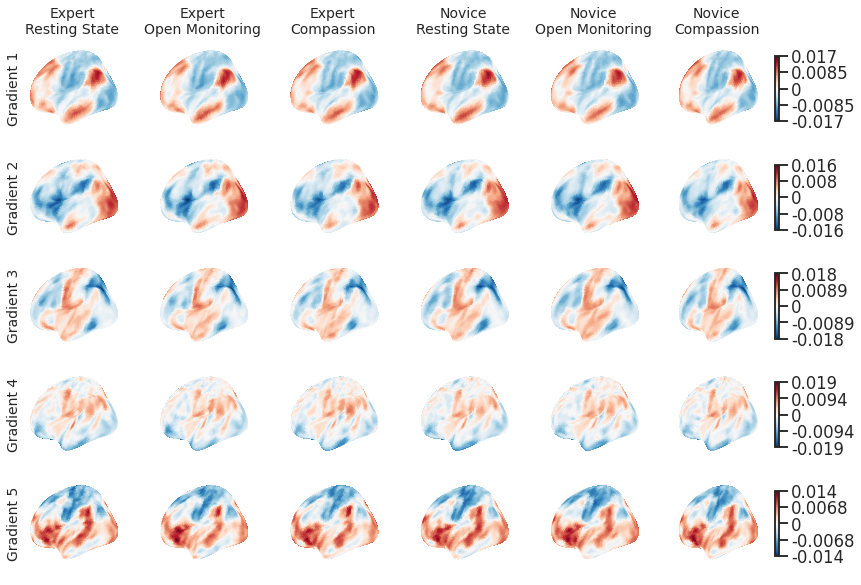

In [91]:
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True)

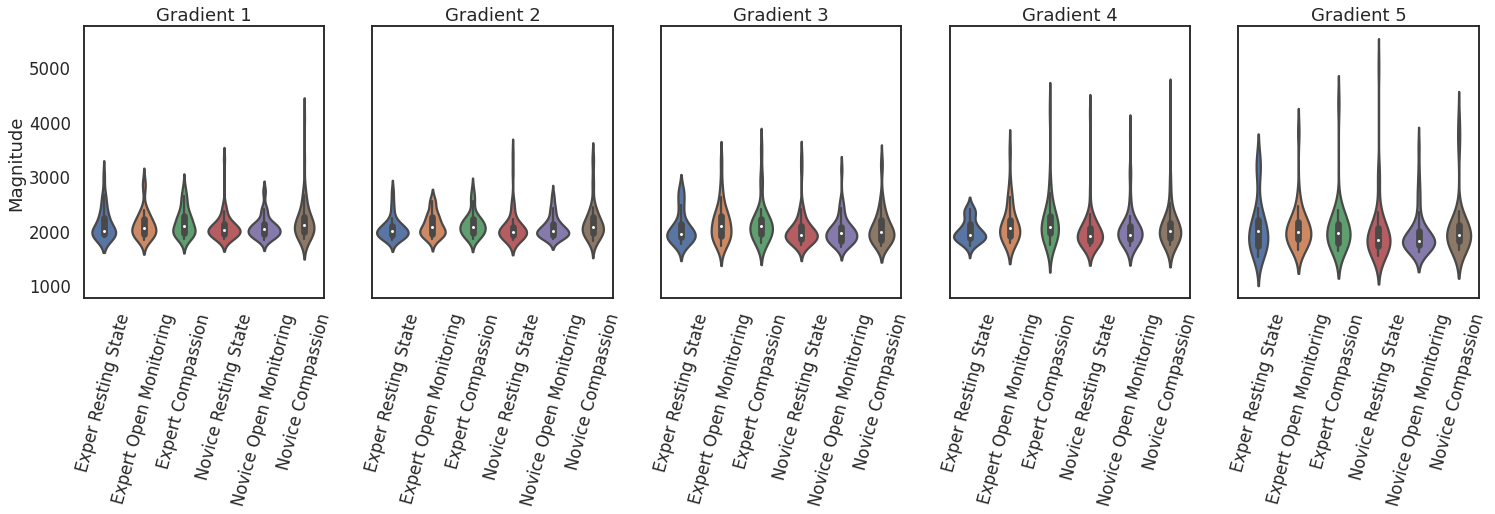

In [92]:
plot_magitude_hists(groups, n_grad=5)

## Joint align

In [96]:
path = Path('/mnt/ssd3/ronan/data/joint_mapalign_01-04')
flag = '_joint'
ftype = 'h5'
source='gcca' # Yeah it's weird...

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

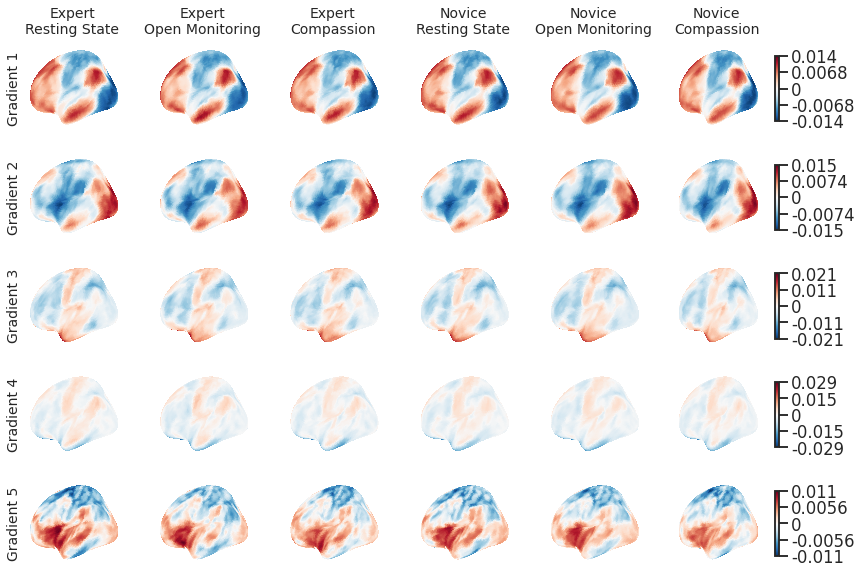

In [98]:
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True)

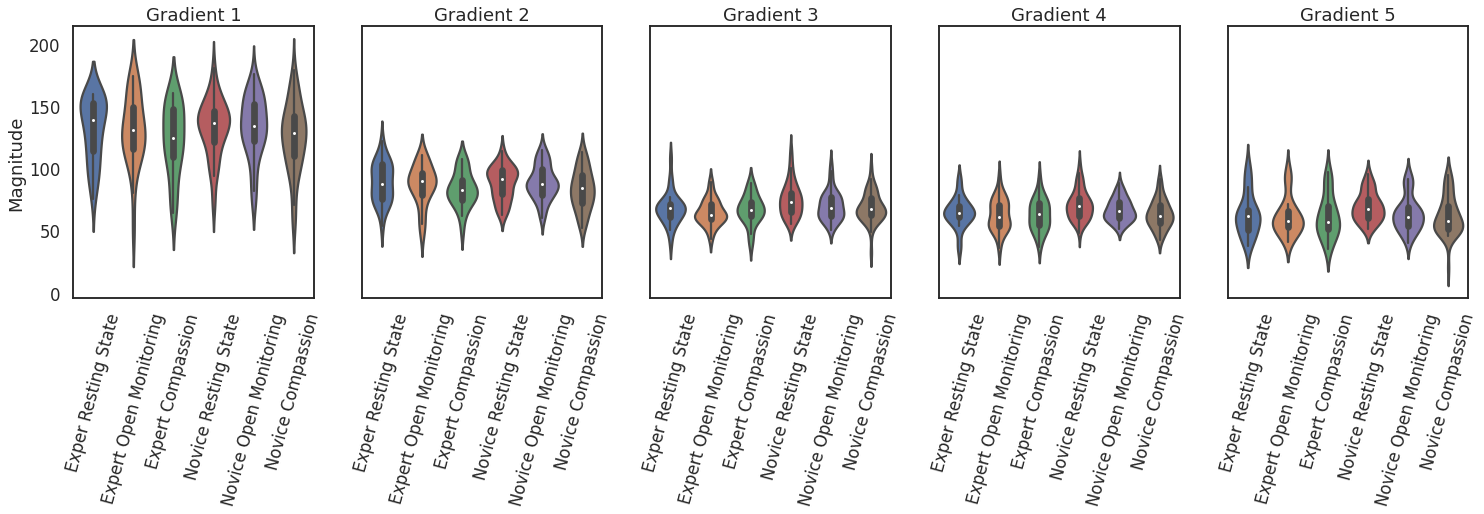

In [99]:
plot_magitude_hists(groups, n_grad=5)

In [100]:
path = Path('/mnt/ssd3/ronan/data/joint_mapalign_12-30/')
flag = '_joint'
ftype = 'h5'
source='gcca' # Yeah it's weird...

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

## Group ICA (not prewhitened)

In [103]:
path = Path('/mnt/ssd3/ronan/data/groupica_raw_03-01')
flag = '_groupica'
ftype = 'h5'
source='gcca' # Yeah it's weird...

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

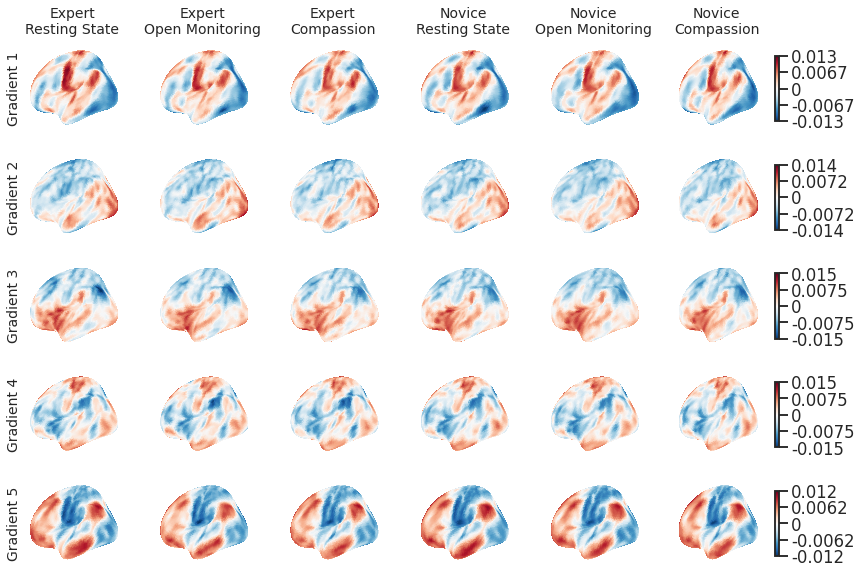

In [105]:
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True)

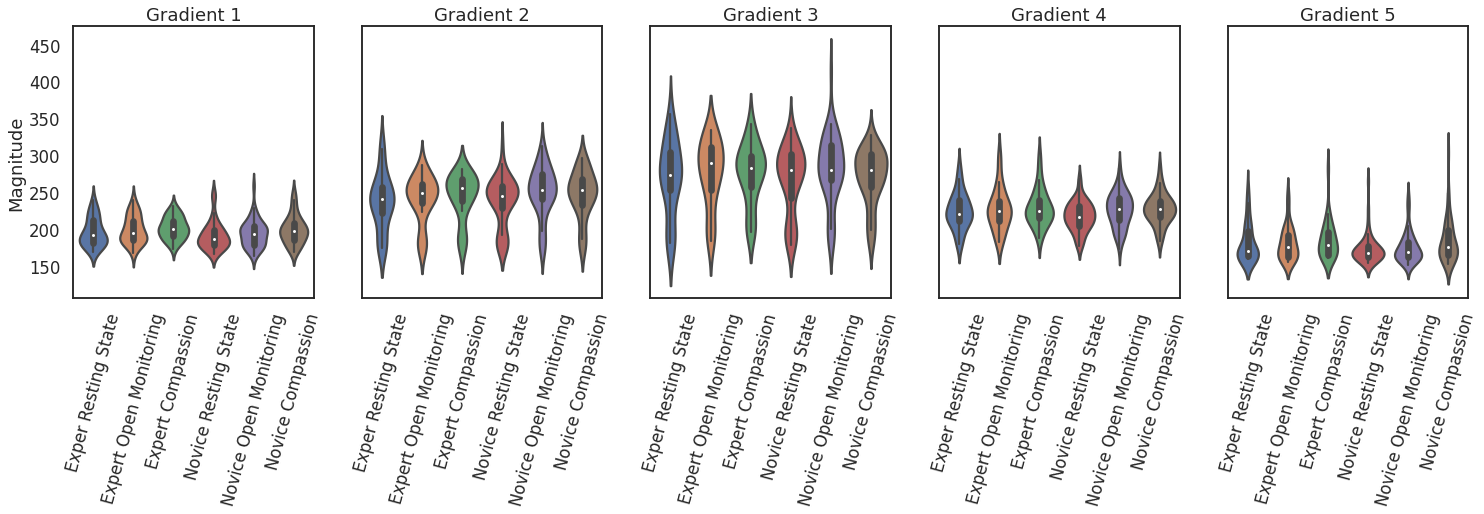

In [106]:
plot_magitude_hists(groups, n_grad=5)

## Group ICA (prewhitened)

In [107]:
path = Path('/mnt/ssd3/ronan/data/groupica_raw_prewhitened_03-01')
flag = '_groupica'
ftype = 'h5'
source='gcca' # Yeah it's weird...

groups, labels, subjs = get_latents(
    path, flag=flag, ids=True, ftype=ftype, source=source, as_groups=True
)

<Figure size 432x288 with 0 Axes>

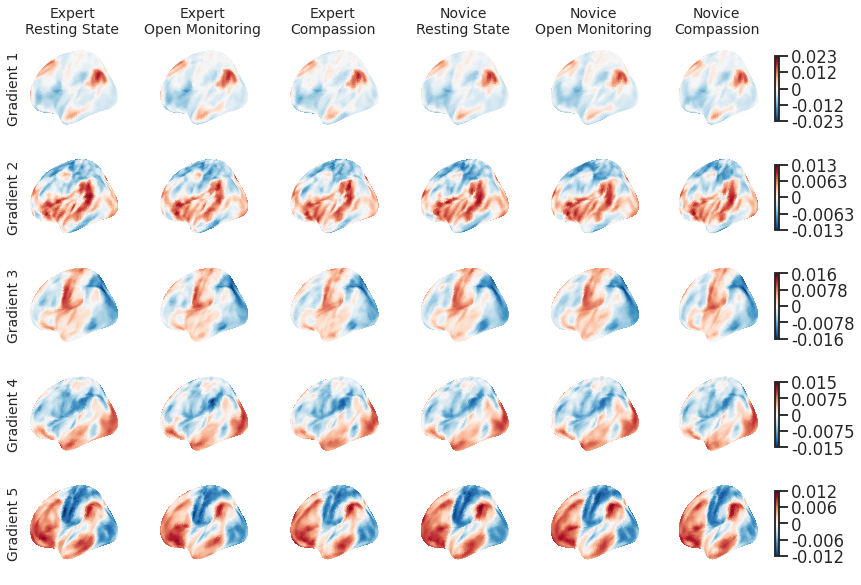

In [108]:
visualize_groups(groups, n_embed=5, stat=np.mean, normed=True)

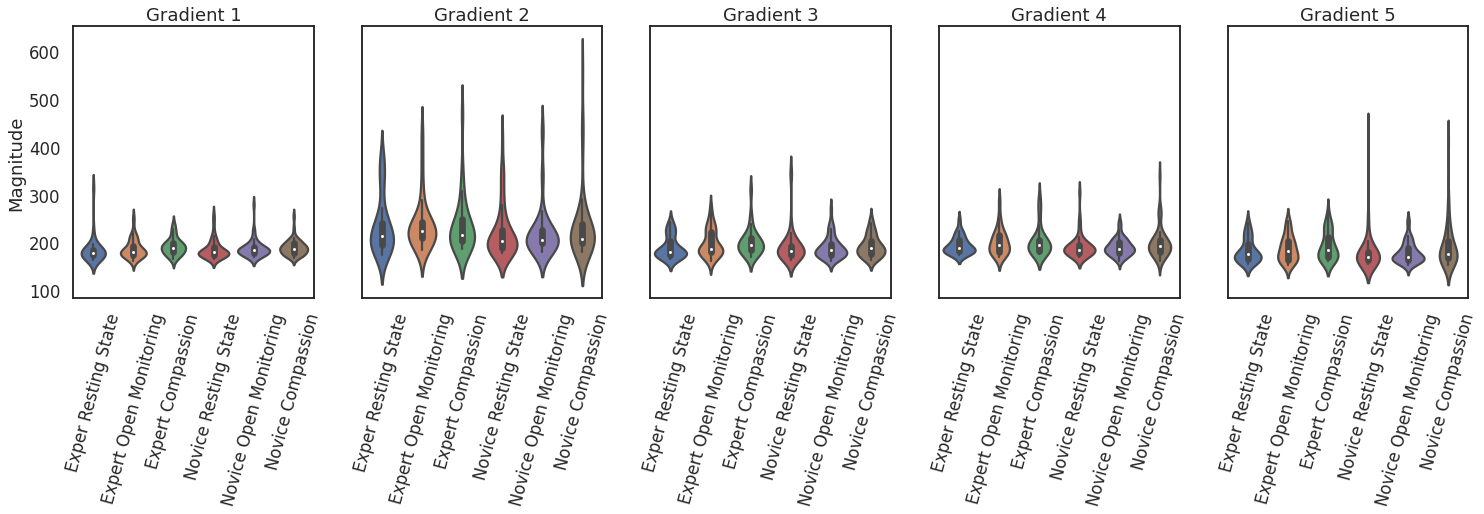

In [109]:
plot_magitude_hists(groups, n_grad=5)